In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(4, 4))
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [5]:
# 1 point
def scale(X):
    X_scaled=(X-np.mean(X))/np.std(X)
    return X_scaled

In [6]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [7]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, copy=True, with_mean=True, with_std=True):
        # your code here
        self.copy=copy
        self.with_mean=with_mean
        self.with_std=with_std
        
    def fit(self, X, y=None):
        # your code here
        self.X_mean = np.mean(X)
        self.X_std = np.std(X)
        return self

    def transform(self, X, y=None, copy=None):
        # your code here
        return (X-self.X_mean)/self.X_std

In [8]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let’s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [9]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[ 7.49090743, -1.24423071],
       [-1.1528801 ,  0.74498556],
       [ 4.15285502,  2.23764968],
       ...,
       [11.22838698,  3.98796891],
       [12.7214388 ,  4.47178985],
       [23.66850096,  5.85458604]])

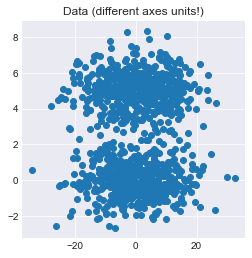

In [10]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

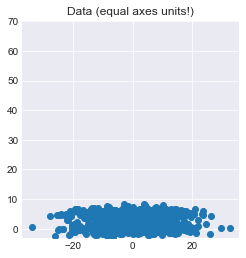

In [11]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

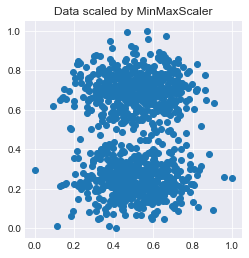

In [12]:
## your code
scaler_minmax = MinMaxScaler()
data_scaled_minmax = scaler_minmax.fit_transform(data)
plot_scatter(data_scaled_minmax[:, 0], data_scaled_minmax[:, 1], 
             auto_scaled=False, title='Data scaled by MinMaxScaler')

### StandardScaler (0.5 point)

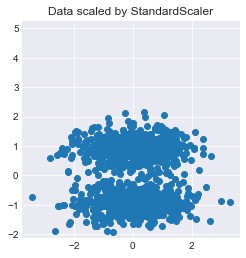

In [13]:
## your code
scaler_stsc = StandardScaler()
data_scaled_stsc = scaler_stsc.fit_transform(data)
plot_scatter(data_scaled_stsc[:, 0], data_scaled_stsc[:, 1], 
             auto_scaled=False, title='Data scaled by StandardScaler')

### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


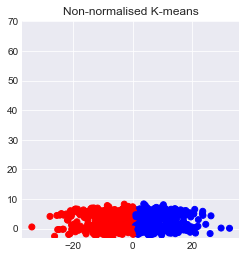

In [14]:
## your code
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)

y_kmeans = kmeans.fit_predict(data)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False, 
                     clusters=y_kmeans, title='Non-normalised K-means')

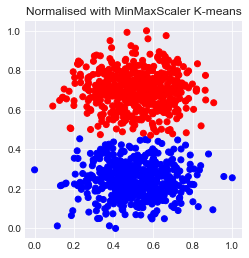

In [15]:
scaler_minmax = MinMaxScaler()
data_scaled_minmax = scaler_minmax.fit_transform(data)
y_kmeans_minmax = kmeans.fit_predict(data_scaled_minmax)
plot_scatter(data_scaled_minmax[:, 0], data_scaled_minmax[:, 1], 
                     auto_scaled=False, clusters=y_kmeans_minmax, 
             title='Normalised with MinMaxScaler K-means' )

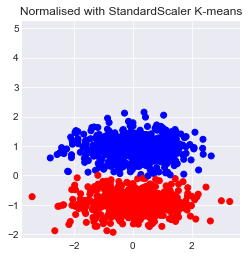

In [16]:
scaler_stsc = StandardScaler()
data_scaled_stsc = scaler_stsc.fit_transform(data)
y_kmeans_stsc = kmeans.fit_predict(data_scaled_stsc)
plot_scatter(data_scaled_stsc[:, 0], data_scaled_stsc[:, 1], 
                     auto_scaled=False, clusters=y_kmeans_stsc, 
             title='Normalised with StandardScaler K-means' )

## Exercise  3 - Preprocessing Pipeline (2 points)

In [17]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

Let's create a Pipeline to gather all pre-processing steps before doing the actual learning.

In [18]:
def make_model(scaler=False, feature_selector=False):
    if scaler == StandardScaler:
        scaling = StandardScaler()
    elif scaler == MinMaxScaler:
        scaling = MinMaxScaler()
    else:
        scaling = None
        
    if feature_selector == RandomForestClassifier:
        selection_model = RandomForestClassifier(random_state=42)
        feature_selection = SelectFromModel(estimator=selection_model)
    elif feature_selector == LogisticRegression:
        selection_model = LogisticRegression(solver='liblinear', penalty='l1', max_iter=2000)
        feature_selection = SelectFromModel(estimator=selection_model)
    else:
        feature_selection = None

    classification = LogisticRegression(solver='liblinear', penalty='l1', max_iter=2000)
    
    pipeline = Pipeline([('scaler', scaling),
                      ('feature_selector', feature_selection),
                      ('classifier', classification)])  
    return pipeline

In [19]:
def print_scores(model, X_train, X_val, y_train, y_val):
    model.fit(X_train, y_train)

    print('------------------------------------------')
    print(f'Scaler: {model["scaler"]}\nFeatures selector: {model["feature_selector"]}\nClassifier: {model["classifier"]}\n')
    print(f'Train accuracy: {model.score(X_train, y_train)}')
#     print(f'Train accuracy_score: {accuracy_score(y_train, model.predict(X_train))}')
    print(f'Val accuracy: {model.score(X_val, y_val)}')
#     print(f'Val accuracy_score: {accuracy_score(y_val, model.predict(X_val))}')
    print(f'Number of features: {model["classifier"].coef_.shape[1]}\n')


Now let's train the model LogisticRegression(solver='liblinear', penalty='l1') on raw wine_train data; on wine_train data scaled with StandardScaler(); on wine_train data scaled with StandardScaler() and features selected with RandomForestClassifier(). Let's measure accuracy on wine_val dataset and count the number of selected features in all 3 approaches. 

In [20]:
model_orig = make_model()
print_scores(model_orig, wine_train, wine_val, wine_labels_train, wine_labels_val)

model_scaledSt = make_model(scaler=StandardScaler)
print_scores(model_scaledSt, wine_train, wine_val, wine_labels_train, wine_labels_val)

model_selectedSR = make_model(scaler=StandardScaler, feature_selector=RandomForestClassifier)
print_scores(model_selectedSR, wine_train, wine_val, wine_labels_train, wine_labels_val)


------------------------------------------
Scaler: None
Features selector: None
Classifier: LogisticRegression(max_iter=2000, penalty='l1', solver='liblinear')

Train accuracy: 0.967741935483871
Val accuracy: 0.9814814814814815
Number of features: 13

------------------------------------------
Scaler: StandardScaler()
Features selector: None
Classifier: LogisticRegression(max_iter=2000, penalty='l1', solver='liblinear')

Train accuracy: 1.0
Val accuracy: 0.9814814814814815
Number of features: 13

------------------------------------------
Scaler: StandardScaler()
Features selector: SelectFromModel(estimator=RandomForestClassifier(random_state=42))
Classifier: LogisticRegression(max_iter=2000, penalty='l1', solver='liblinear')

Train accuracy: 0.9838709677419355
Val accuracy: 1.0
Number of features: 6



As we can observe, test accuracies on the original data and data after standartization coinside. 

After applying feature selection, the number of features decreased significantly from 13 to 6, and the model accuracy on wine_val increased to 1.0.

In [21]:
wine_data.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


Perhaps just scaling did not improve test accuracy because the ranges of all features (except 'proline') in wine dataset are similar.

And after applying the model for feature evaluation 7 features have been considered as useless and after removal them from the model test accuracy increased.

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [22]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [23]:
## your code
X = wine_data
X_scaled = (X - np.mean(X))/np.std(X)
S = 1/(X.shape[0] - 1) * X_scaled.T @ X_scaled

If your code is correct, the following assert should be Ok.

In [24]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [25]:
from scipy.optimize import minimize

def objective(x):
    # your code: write objective of the problem (don't forget that scipy does min while we need max)
    return  -(x.T @ S @ x)
    
def norm_constraint(x):
    # your code: constaraint norm of x to be 1, function should return 0 if constraint holds
    return np.linalg.norm(x) - 1

con1 = {'type': 'eq', 'fun': norm_constraint}

x0 = np.ndarray(len(S))  # your code: initial vector to start optimization

sol = minimize(objective, 
               x0, 
               constraints = [con1]
              )
x0 = sol.x

Hurray! We have first vector! Let's do another one.

In [26]:
def orthogonality_constraint(x):
    # your code: x should be orthogonal to x0, function should return 0 if constraint holds
    return x0.T @ x
    
con2 = {'type': 'eq', 'fun': orthogonality_constraint}

x1 =  np.ndarray(len(S)) # your code: initial vector to start optimization

sol = minimize(objective, 
               x1, 
               constraints = [con1, con2] #your code
              )

x1 = sol.x

If your solution is correct, the following asserts should be Ok.

In [27]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

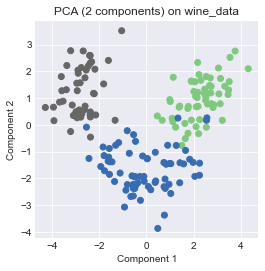

In [28]:
# X = wine_data
# X_scaled = (X - np.mean(X))/np.std(X)

W = np.array((x0,x1))
wine_data_x0 = X_scaled @ W.T[:,0]
wine_data_x1 = X_scaled @ W.T[:,1]

plt.figure(figsize=(4, 4))
plt.scatter(wine_data_x0, wine_data_x1, c=wine_labels, cmap='Accent')
plt.grid(True)
plt.title('PCA (2 components) on wine_data')
plt.xlabel('Component 1')
plt.ylabel('Component 2') 
plt.show()


## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [29]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

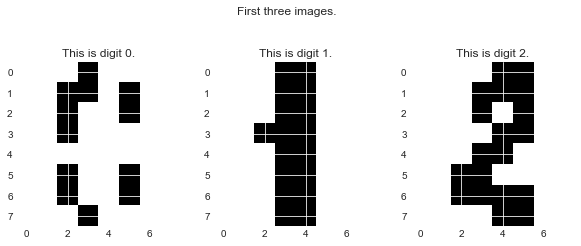

In [30]:
f, ax = plt.subplots(1,3,figsize=(10,4))
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [31]:
# your code here
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [32]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [33]:
clf = RandomForestClassifier(max_depth=13, random_state = 42)

# your code here
clf.fit(X_train, y_train)

acc = clf.score(X_val, y_val) # your code here
print(acc)

0.9938271604938271


In [34]:
assert acc > 0.98

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [35]:
# ! pip install boruta

In [36]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

# your code here: do run the boruta 
feat_selector.fit(np.array(X_train), np.array(y_train))

BorutaPy(estimator=RandomForestClassifier(max_depth=13, n_estimators=62,
                                          random_state=RandomState(MT19937) at 0x1255AD440),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x1255AD440)

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

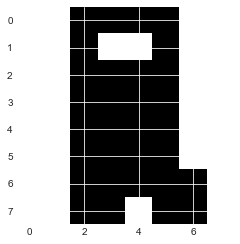

In [37]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

At the end let us redo  classification but only with selected features

In [38]:
clf = RandomForestClassifier(max_depth=13, random_state = 42)

# your code here
supported_columns = X_train.columns[feat_selector.support_].to_list()
clf.fit(X_train[supported_columns], y_train)

acc = clf.score(X_val[supported_columns], y_val) # your code here
print(acc)

0.9938271604938271


In [39]:
assert acc > 0.99

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market